In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
from matplotlib.ticker import FormatStrFormatter
import calendar
import pandas as pd
from functions import *
import statistics as st
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats
from scipy.special import erf
%matplotlib inline

In [2]:
%store -r tceq_cams49_pm10_2019
%store -r tceq_cams49_pm10_2020
%store -r tceq_cams49_pm10_2021

%store -r tceq_cams49_pm25_2019
%store -r tceq_cams49_pm25_2020
%store -r tceq_cams49_pm25_2021

In [3]:
tceq_cams49_pm10_all=[tceq_cams49_pm10_2019,tceq_cams49_pm10_2020,tceq_cams49_pm10_2021]
tceq_cams49_pm25_all=[tceq_cams49_pm25_2019,tceq_cams49_pm25_2020,tceq_cams49_pm25_2021]


In [4]:
file_path_nrel=r'C:\\Users\\lehri\\Documents\\GitHub\\dust_solar_power\\NREL_NSRDB\\'

In [5]:
precipitation_data=pd.read_csv(file_path_nrel+'POWER_Point_Hourly_20190101_20220101_031d67N_0106d29W_LST.csv',skiprows=9)

In [6]:
precipitation_data_indexed=precipitation_data.assign(Datetime=[f"{str(year)}-{str(month)}-{str(day)} {str(hour)}:00" for year, month, day, hour in zip(precipitation_data['YEAR'], precipitation_data['MO'], precipitation_data['DY'], precipitation_data['HR'])])
precipitation_data_indexed.set_index(precipitation_data_indexed['Datetime'],inplace=True)
precipitation_data_indexed.drop(columns=['YEAR','MO','DY','HR','Datetime'],inplace=True)
precipitation_data_indexed.index=precipitation_data_indexed.index.astype("datetime64[ns]")
#PRECTOTCORR:'Precipit

In [7]:
precip_2019=precipitation_data_indexed.loc['2019-01-01 00:00':'2020-01-01 00:00'][:-1]
precip_2020=precipitation_data_indexed.loc['2020-01-01 00:00':'2021-01-01 00:00'][:-1]
precip_2021=precipitation_data_indexed.loc['2021-01-01 00:00':'2022-01-01 00:00'][:-1]

In [8]:
print(precip_2019['PRECTOTCORR'].mean(),st.median(precip_2019['PRECTOTCORR']),precip_2019['PRECTOTCORR'].std())
print(precip_2020['PRECTOTCORR'].mean(),st.median(precip_2020['PRECTOTCORR']),precip_2020['PRECTOTCORR'].std())
print(precip_2021['PRECTOTCORR'].mean(),st.median(precip_2021['PRECTOTCORR']),precip_2021['PRECTOTCORR'].std())

print(precip_2019['PRECTOTCORR'].sum())
print(precip_2020['PRECTOTCORR'].sum())
print(precip_2021['PRECTOTCORR'].sum())


0.02238926940639269 0.0 0.12482337908655616
0.014516165755919857 0.0 0.10454193208786393
0.030643835616438356 0.0 0.15706070025677765
196.12999999999997
127.51000000000002
268.44


In [9]:
precip_2019_daily=precip_2019.resample('1D').mean()
precip_2020_daily=precip_2020.resample('1D').mean()
precip_2021_daily=precip_2021.resample('1D').mean()
precip_all_years=[precip_2019,precip_2020,precip_2021]
precip_daily_all_years=[precip_2019_daily,precip_2020_daily,precip_2021_daily]

In [10]:
# cm/s to m/s
SETTLING_VELOCITY_PM1025=0.4/100
SETTLING_VELOCITY_PM25=0.09/100
fort_bliss_tilt=15
#convert time step from seconds to hours
T=1*60*60
#in mm
PRECIP_THRESHOLD=1
#ratio
SR_THRESHOLD=0.8

In [11]:
tceq_cams49_pm10_25=pd.DataFrame()
tceq_cams49_pm10_25_2019=(tceq_cams49_pm10_2019-tceq_cams49_pm25_2019).to_numpy().flatten(order='C')
tceq_cams49_pm10_25_2019=pd.DataFrame({'PM':tceq_cams49_pm10_25_2019})
tceq_cams49_pm10_25_2019.set_index(pd.date_range(start=f"2019-01-01",end=f"2020-01-01",freq="h")[:-1],inplace=True)
tceq_cams49_pm25_2019_flat=pd.DataFrame({'PM':tceq_cams49_pm25_2019.to_numpy().flatten(order='C')})
tceq_cams49_pm25_2019_flat.set_index(pd.date_range(start=f"2019-01-01",end=f"2020-01-01",freq="h")[:-1],inplace=True)
tceq_cams49_pm10_2019_flat=pd.DataFrame({'PM':tceq_cams49_pm10_2019.to_numpy().flatten(order='C')})
tceq_cams49_pm10_2019_flat.set_index(pd.date_range(start=f"2019-01-01",end=f"2020-01-01",freq="h")[:-1],inplace=True)                                    

In [12]:
def get_flat_pm(pm_df,year):
    df_flat_copy=pd.DataFrame({'PM':pm_df.to_numpy().flatten(order='C')})
    df_flat_copy.set_index(pd.date_range(start=f"{year}-01-01",end=f"{year+1}-01-01",freq="h")[:-1],inplace=True)
    return df_flat_copy

In [13]:
def get_daily_sr(pm10_25_flat,pm25_df_flat,tilt):
    mar=SETTLING_VELOCITY_PM1025*pm10_25_flat+SETTLING_VELOCITY_PM25*pm25_df_flat*np.cos(np.deg2rad(tilt))*T
    return mar

In [14]:
mar_all=[]
mar_all_clean=[]
for year in [2019,2020,2021]:
    pm25_df_flat=get_flat_pm(tceq_cams49_pm25_all[year-2019],year)
    pm10_df_flat=get_flat_pm(tceq_cams49_pm10_all[year-2019],year)
    pm10_25_flat=(pm10_df_flat-pm25_df_flat)

    pm10_25_flat[pm10_25_flat<=0]=0.
    pm10_df_flat[pm10_df_flat<=0]=0.
    pm25_df_flat[pm25_df_flat<=0]=0.

    pm10_25_flat=pm10_25_flat/1e+6
    pm10_df_flat=pm10_df_flat/1e+6
    pm25_df_flat=pm25_df_flat/1e+6

    mass_accum_rate_hourly=get_daily_sr(pm10_25_flat,pm25_df_flat,fort_bliss_tilt)
    precip_mask=precip_all_years[year-2019]>=PRECIP_THRESHOLD
    mass_accum_rate_hourly[(precip_mask==True).all(1)]=0.
    mar_cum=mass_accum_rate_hourly.copy(deep=True)
    #the column with PM here is actually the MAR
    mar_cum['Group'] = (mar_cum['PM'] == 0).cumsum()
    mar_cum['CumsumReset'] = mar_cum.groupby('Group')['PM'].cumsum()
    mar_cum[mar_cum['CumsumReset']<0]=0.
    mar_cum['SR']=1-34.37*erf(0.17*mar_cum['CumsumReset']**0.8473)
    mar_cum[mar_cum['SR']<0]=0.

    #Calculate a modified Soiling Rate accounting for cleaning if the SR falls below a certain threshold
    mar_cum_clean=mass_accum_rate_hourly.copy(deep=True)
    precip_mask=precip_all_years[year-2019]>=PRECIP_THRESHOLD
    mar_cum_clean[(precip_mask==True).all(1)]=-999
    mar_cum_clean[mar_cum_clean.isnull().all(1)]=0.
    ls = []  
    cumsum = 0
    last_reset = 0
    ls_sr=[]
    sr=0
    num_cleaning_events=0
    for index, row in mar_cum_clean.iterrows():
        if row['PM'] != -999.0:
            cumsum += row['PM']
            sr=1-34.37*erf(0.17*cumsum**0.8473)
        elif row['PM'] == -999.0:
            cumsum = 0
            sr=1-34.37*erf(0.17*cumsum**0.8473)
    
        if sr<SR_THRESHOLD:
            cumsum = 0
            num_cleaning_events+=1
        ls.append(cumsum)
        ls_sr.append(sr)
    mar_cum_clean['cumsum'] = ls
    mar_cum_clean['SR']=ls_sr
    mar_cum_clean[mar_cum_clean['SR']<0]=0.

    #sr_mask=mar_cum['SR']<0.5
    #mar_cum['Cleaning']
    #mar_cum['Cleaning'][(sr_mask==True).all(1)]=0.
    mar_all_clean.append(mar_cum_clean)
    mar_all.append(mar_cum)
    print(f"Num. Natural Cleaning Events {year}: ",mar_cum['Group'].max())
    print(f"Num. Artificial Cleaning Events {year}: ",num_cleaning_events)
    print(f"Mean, Std SR {year}: ",np.round(mar_cum['SR'].mean(),2),np.round(mar_cum['SR'].std(),2))
    print(f"Mean, Std, Max MAR {year}: ",np.round(mar_cum['CumsumReset'].mean(),2),np.round(mar_cum['CumsumReset'].std(),2),np.round(mar_cum['CumsumReset'].max(),2))
    
    #mar_cum = mar_cum.drop(columns=['Group'])
    

Num. Natural Cleaning Events 2019:  36
Num. Artificial Cleaning Events 2019:  7
Mean, Std SR 2019:  0.85 0.12
Mean, Std, Max MAR 2019:  0.01 0.01 0.05
Num. Natural Cleaning Events 2020:  19
Num. Artificial Cleaning Events 2020:  12
Mean, Std SR 2020:  0.61 0.31
Mean, Std, Max MAR 2020:  0.03 0.03 0.11
Num. Natural Cleaning Events 2021:  54
Num. Artificial Cleaning Events 2021:  11
Mean, Std SR 2021:  0.65 0.27
Mean, Std, Max MAR 2021:  0.03 0.03 0.11


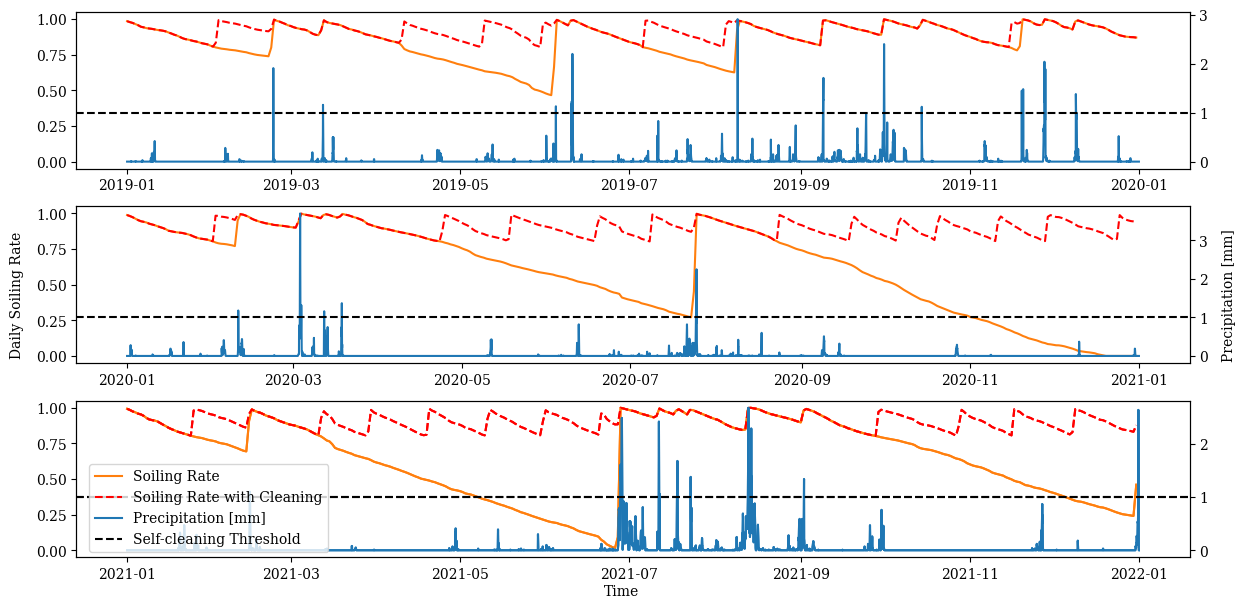

In [15]:
fig,ax=plt.subplots(3,1,sharey=True,figsize=(12,6))

for i in [0,1,2]:
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    #date_index=pd.date_range(start=f"{i+2019}-01-01",end=f"{i+2020}-01-01",freq="h")[:-1]
    ax2=ax[i].twinx()
    precip_year=precip_all_years[i]
    mar_cum=mar_all[i]
    ax[i].plot(mar_cum['SR'].resample('1D').mean(),color="tab:orange")
    ax[i].plot(mar_all_clean[i]['SR'].resample('1D').mean(),color='red',linestyle='dashed')
    ax2.plot(precip_year,color="tab:blue")
    ax2.axhline(y=1,linestyle='dashed',color='black')
    if i==2:
        ax[i].plot(mar_cum['SR'].resample('1D').mean(),color="tab:orange",label='Soiling Rate')
        ax[i].plot(mar_all_clean[i]['SR'].resample('1D').mean(),color='red',label='Soiling Rate with Cleaning',linestyle='dashed')
        ax2.plot(precip_year,color="tab:blue",label='Precipitation [mm]')
        ax2.axhline(y=1,label='Self-cleaning Threshold',linestyle='dashed',color='black')       

fig.text(-0.01, 0.5, 'Daily Soiling Rate', va='center', rotation='vertical')
fig.text(1, 0.5, 'Precipitation [mm]', va='center', rotation='vertical')
fig.text(0.5,0,'Time', ha='center')
fig.legend(loc="lower left", bbox_to_anchor=(.05,.06))
fig.tight_layout(pad=1)

plt.show()

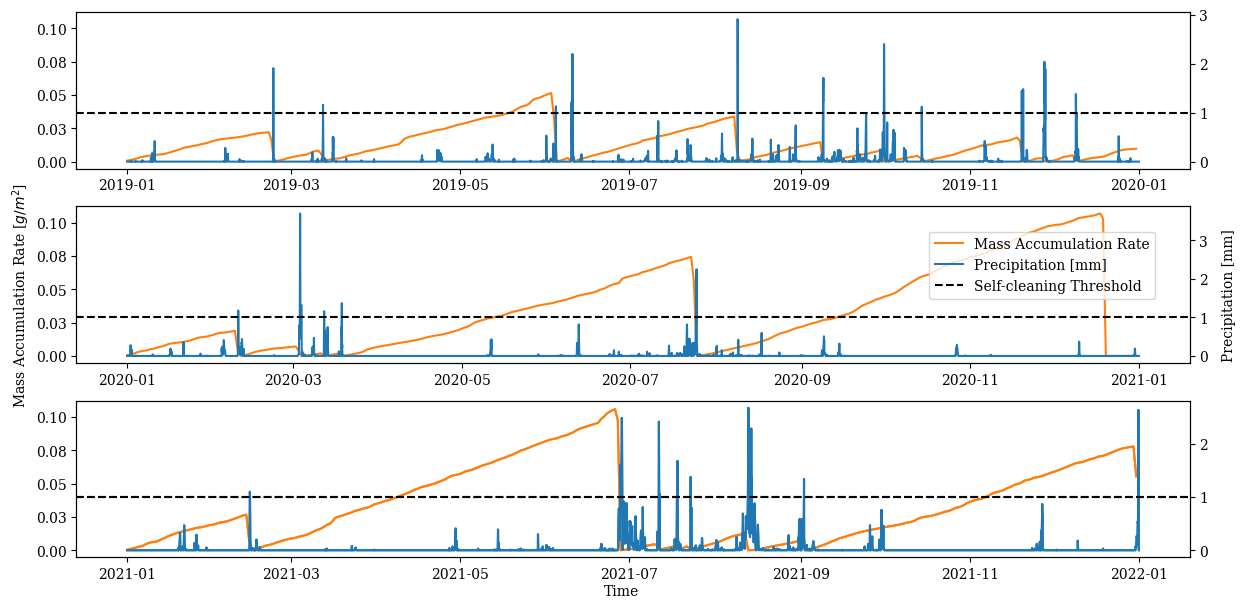

In [16]:
fig,ax=plt.subplots(3,1,sharey=True,figsize=(12,6))

for i in [0,1,2]:
    #date_index=pd.date_range(start=f"{i+2019}-01-01",end=f"{i+2020}-01-01",freq="h")[:-1]
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax2=ax[i].twinx()
    precip_year=precip_all_years[i]
    mar_cum=mar_all[i]
    ax[i].plot(mar_cum['CumsumReset'].resample('1D').mean(),color="tab:orange")
    ax2.plot(precip_year,color="tab:blue")
    ax2.axhline(y=1,linestyle='dashed',color='black')
    if i==2:
        ax[i].plot(mar_cum['CumsumReset'].resample('1D').mean(),color="tab:orange",label='Mass Accumulation Rate')
        ax2.plot(precip_year,color="tab:blue",label='Precipitation [mm]')
        ax2.axhline(y=1,label='Self-cleaning Threshold',linestyle='dashed',color='black') 
        
fig.text(-0.01, 0.5, 'Mass Accumulation Rate [$g/m^{2}$]', va='center', rotation='vertical')
fig.text(1, 0.5, 'Precipitation [mm]', va='center', rotation='vertical')
fig.text(0.5,0,'Time', ha='center')
fig.legend(loc="center right", bbox_to_anchor=(.95,.55))
fig.tight_layout(pad=1)
plt.show()

In [17]:
%store mar_all
%store mar_all_clean

Stored 'mar_all' (list)
Stored 'mar_all_clean' (list)


In [21]:
precip_all_years[0].iloc[:,0]

Datetime
2019-01-01 00:00:00    0.0
2019-01-01 01:00:00    0.0
2019-01-01 02:00:00    0.0
2019-01-01 03:00:00    0.0
2019-01-01 04:00:00    0.0
                      ... 
2019-12-31 19:00:00    0.0
2019-12-31 20:00:00    0.0
2019-12-31 21:00:00    0.0
2019-12-31 22:00:00    0.0
2019-12-31 23:00:00    0.0
Name: PRECTOTCORR, Length: 8760, dtype: float64

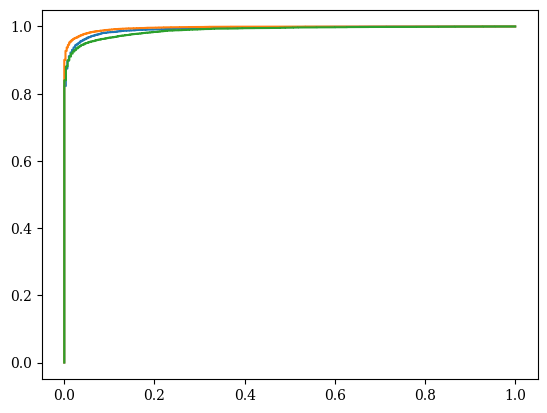

In [26]:
precip_norm1=normalize(precip_all_years[0].iloc[:,0])
precip_norm2=normalize(precip_all_years[1].iloc[:,0])
precip_norm3=normalize(precip_all_years[2].iloc[:,0])

ecdf1=ECDF(precip_norm1)
ecdf2=ECDF(precip_norm2)
ecdf3=ECDF(precip_norm3)

plt.step(ecdf1.x,ecdf1.y)
plt.step(ecdf2.x,ecdf2.y)
plt.step(ecdf3.x,ecdf3.y)

plt.show()